# TPGMM for Gait Data with Transformed Reference Frame

In [1]:
import sys
sys.path.append("/".join(sys.path[0].split("/")[:-1]))
import json
import numpy as np
from tpgmm.tpgmm.tpgmm import TPGMM
from tpgmm.gmr.gmr import GaussianMixtureRegression
from tpgmm.utils.plot.plot import plot_trajectories, plot_ellipsoids, scatter
import matplotlib.pyplot as plt

Loading gait data json

In [2]:
with open("../data/new_processed_gait_data#39_16.json", "r") as f:
    data = json.load(f)

Trajectories manipulation

In [3]:
# Create separate lists for trajectories from each frame of reference
trajectories_fr1 = []
trajectories_fr2 = []

for demo in data:
    # For FR1, stack spatial features first, then time
    traj1 = np.hstack([
        demo['ankle_pos_FR1'], 
        demo['ankle_pos_FR1_velocity'], 
        demo['ankle_orientation_FR1'],
        demo['time']
    ])
    trajectories_fr1.append(traj1)
    
    # For FR2, stack spatial features first, then time
    traj2 = np.hstack([
        demo['ankle_pos_FR2'], 
        demo['ankle_pos_FR2_velocity'], 
        demo['ankle_orientation_FR2'],
        demo['time']
    ])
    trajectories_fr2.append(traj2)

# Convert lists to numpy arrays
trajectories_fr1 = np.array(trajectories_fr1)
trajectories_fr2 = np.array(trajectories_fr2)

Ploting Input Data

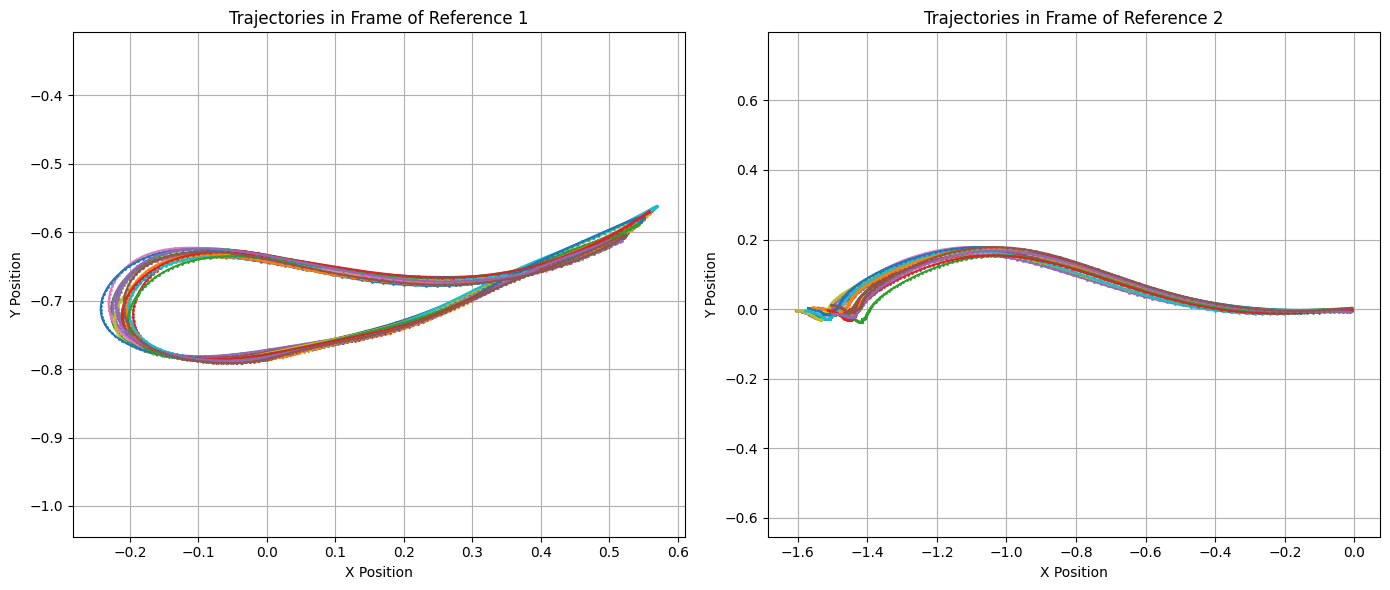

In [4]:
# --- Plotting ---
# Create a figure with two subplots, side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot trajectories for Frame of Reference 1
ax1.set_title('Trajectories in Frame of Reference 1')
ax1.set_xlabel('X Position')
ax1.set_ylabel('Y Position')
for traj in trajectories_fr1:
    # The first two columns are x and y ankle positions
    x_pos = traj[:, 0]
    y_pos = traj[:, 1]
    ax1.plot(x_pos, y_pos, marker='.', linestyle='-', markersize=2)
ax1.grid(True)
ax1.axis('equal')

# Plot trajectories for Frame of Reference 2
ax2.set_title('Trajectories in Frame of Reference 2')
ax2.set_xlabel('X Position')
ax2.set_ylabel('Y Position')
for traj in trajectories_fr2:
    # The first two columns are x and y ankle positions
    x_pos = traj[:, 0]
    y_pos = traj[:, 1]
    ax2.plot(x_pos, y_pos, marker='.', linestyle='-', markersize=2)
ax2.grid(True)
ax2.axis('equal')

# Show the plots
fig.tight_layout()
plt.show()

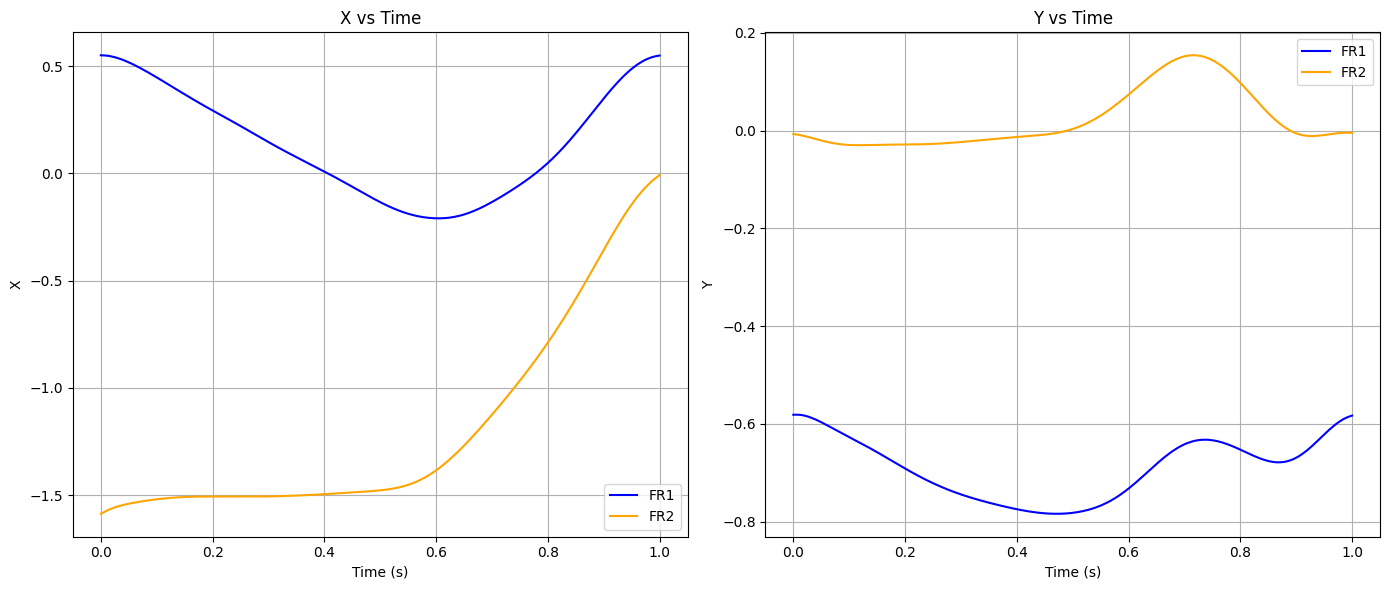

In [5]:

# Create the figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot X vs Time
axs[0].plot(trajectories_fr1[0][:, -1],  trajectories_fr1[0][:, 0], label='FR1', color='blue')
axs[0].plot(trajectories_fr2[0][:, -1],  trajectories_fr2[0][:, 0], label='FR2', color='orange')
axs[0].set_title('X vs Time')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('X')
axs[0].legend()
axs[0].grid()

# Plot Y vs Time
axs[1].plot(trajectories_fr1[0][:, -1],  trajectories_fr1[0][:, 1], label='FR1', color='blue')
axs[1].plot(trajectories_fr2[0][:, -1],  trajectories_fr2[0][:, 1], label='FR2', color='orange')
axs[1].set_title('Y vs Time')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Y')
axs[1].legend()
axs[1].grid()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

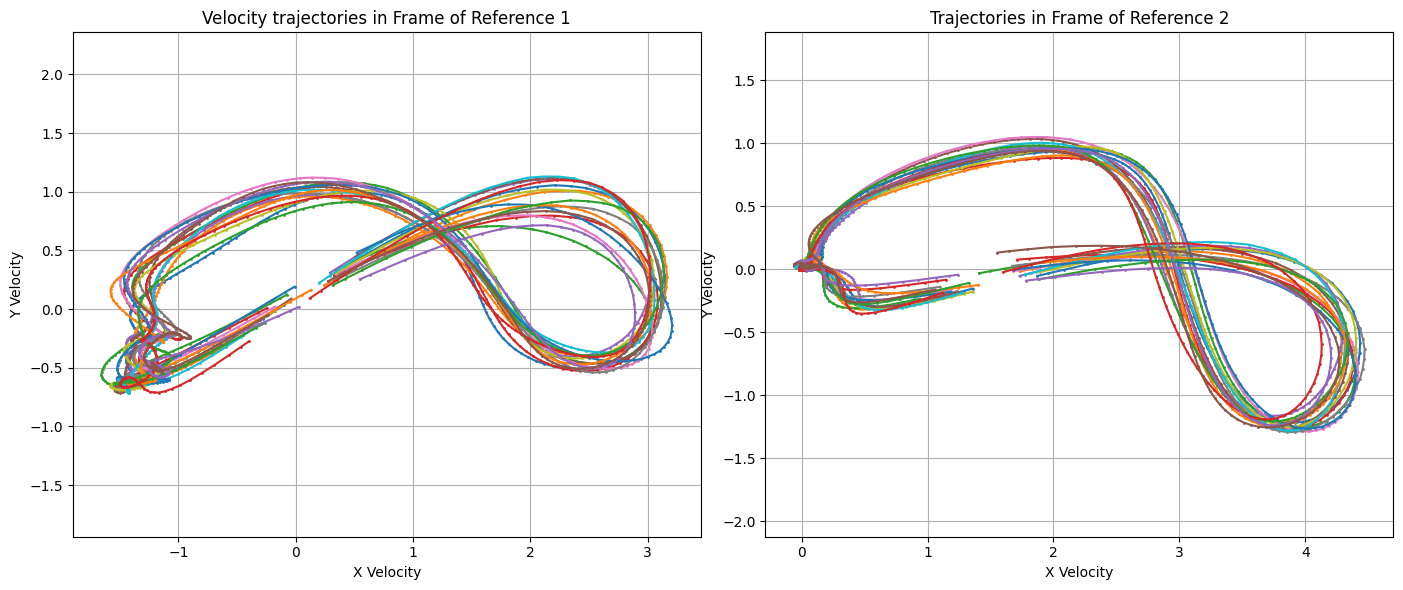

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot trajectories for Frame of Reference 1
ax1.set_title('Velocity trajectories in Frame of Reference 1')
ax1.set_xlabel('X Velocity')
ax1.set_ylabel('Y Velocity')
for traj in trajectories_fr1:
    # The first two columns are x and y ankle positions
    x_pos = traj[:, 2]
    y_pos = traj[:, 3]
    ax1.plot(x_pos, y_pos, marker='.', linestyle='-', markersize=2)
ax1.grid(True)
ax1.axis('equal')

# Plot trajectories for Frame of Reference 2
ax2.set_title('Trajectories in Frame of Reference 2')
ax2.set_xlabel('X Velocity')
ax2.set_ylabel('Y Velocity')
for traj in trajectories_fr2:
    # The first two columns are x and y ankle positions
    x_pos = traj[:, 2]
    y_pos = traj[:, 3]
    ax2.plot(x_pos, y_pos, marker='.', linestyle='-', markersize=2)
ax2.grid(True)
ax2.axis('equal')

# Show the plots
plt.tight_layout()
plt.show()

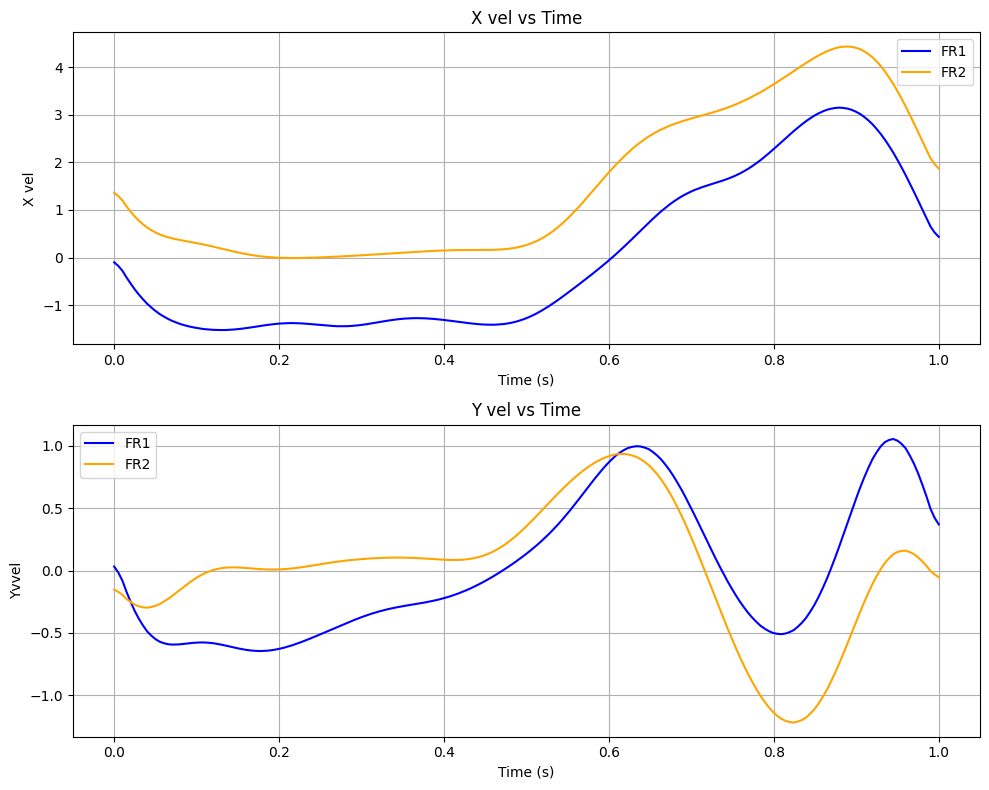

In [7]:
# Create the figure and subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot X vs Time
axs[0].plot(trajectories_fr1[0][:, -1],  trajectories_fr1[0][:, 2], label='FR1', color='blue')
axs[0].plot(trajectories_fr2[0][:, -1],  trajectories_fr2[0][:, 2], label='FR2', color='orange')
axs[0].set_title('X vel vs Time')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('X vel')
axs[0].legend()
axs[0].grid()

# Plot Y vs Time
axs[1].plot(trajectories_fr1[0][:, -1],  trajectories_fr1[0][:, 3], label='FR1', color='blue')
axs[1].plot(trajectories_fr2[0][:, -1],  trajectories_fr2[0][:, 3], label='FR2', color='orange')
axs[1].set_title('Y vel vs Time')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Yvvel')
axs[1].legend()
axs[1].grid()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

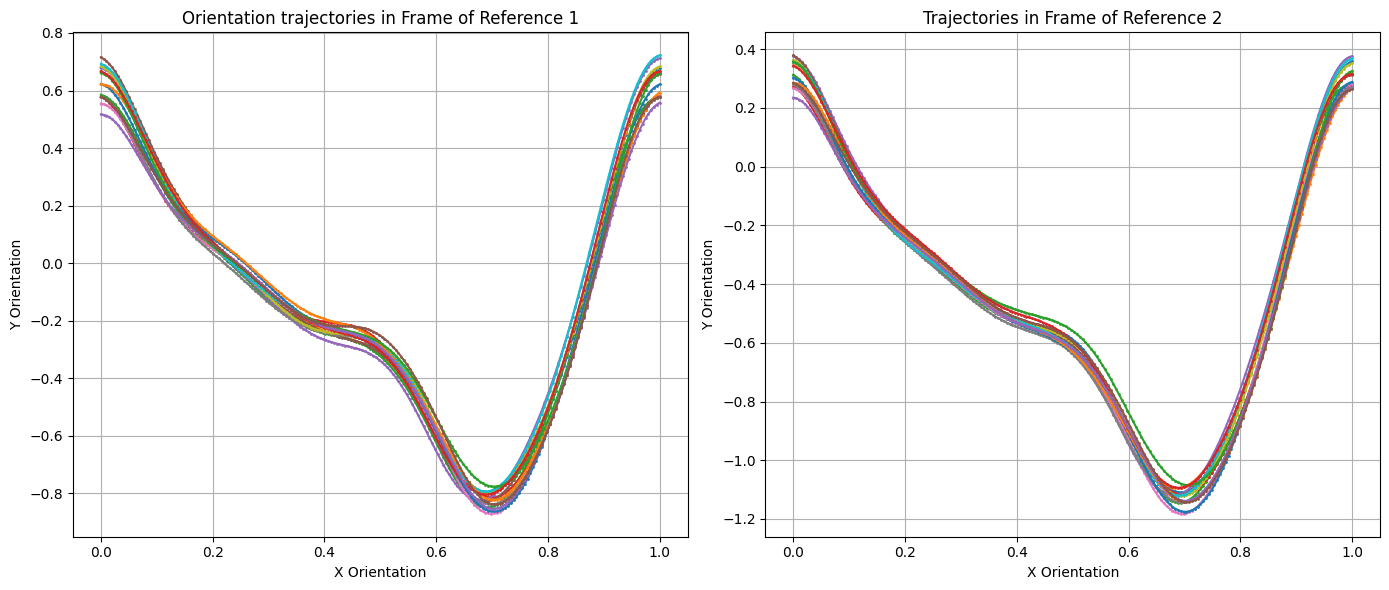

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot trajectories for Frame of Reference 1
ax1.set_title('Orientation trajectories in Frame of Reference 1')
ax1.set_xlabel('X Orientation')
ax1.set_ylabel('Y Orientation')
for traj in trajectories_fr1:
    # The first two columns are x and y ankle positions
    orient = traj[:, 4]
    time = traj[:, 5]
    ax1.plot(time, orient, marker='.', linestyle='-', markersize=2)
ax1.grid(True)
# ax1.axis('equal')

# Plot trajectories for Frame of Reference 2
ax2.set_title('Trajectories in Frame of Reference 2')
ax2.set_xlabel('X Orientation')
ax2.set_ylabel('Y Orientation')
for traj in trajectories_fr2:
    # The first two columns are x and y ankle positions
    orient = traj[:, 4]
    time = traj[:, 5]
    ax2.plot(time, orient, marker='.', linestyle='-', markersize=2)
ax2.grid(True)
# ax2.axis('equal')

# Show the plots
plt.tight_layout()
plt.show()

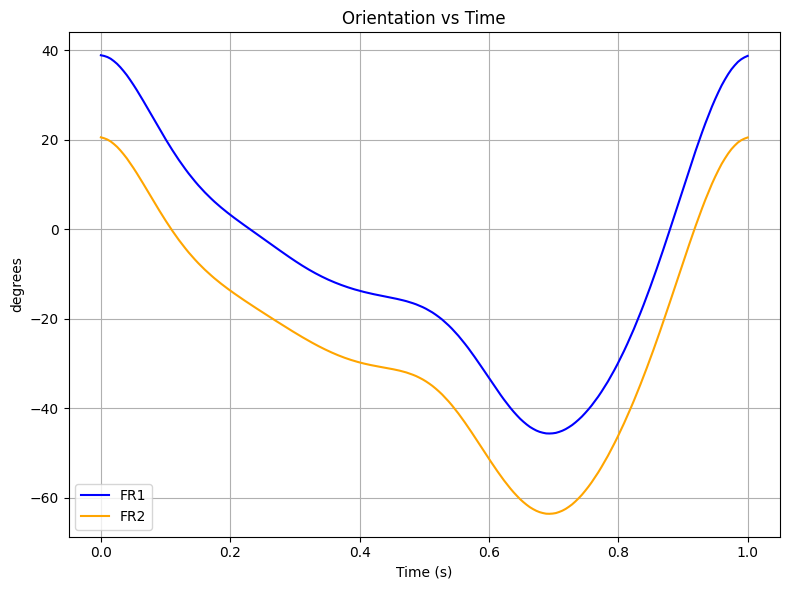

In [9]:
# Create the figure and subplots
fig, ax = plt.subplots(figsize=(8, 6))

# Plot X vs Time
ax.plot(trajectories_fr1[0][:, -1],  np.degrees(trajectories_fr1[0][:, 4]), label='FR1', color='blue')
ax.plot(trajectories_fr2[0][:, -1],  np.degrees(trajectories_fr2[0][:, 4]), label='FR2', color='orange')
ax.set_title('Orientation vs Time')
ax.set_xlabel('Time (s)')
ax.set_ylabel('degrees')
ax.legend()
ax.grid()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

TPGMMM

In [10]:
from sklearn.preprocessing import StandardScaler

# Reshape the data for TPGMM
# The TPGMM expects data in the shape (num_frames, num_points, num_features)
# We have 2 frames of reference (FR1 and FR2)

# Stack the data for the two frames
num_trajectories, num_samples, num_features = trajectories_fr1.shape
reshaped_trajectories = np.stack([trajectories_fr1, trajectories_fr2], axis=0)

# Reshape to (num_frames, num_trajectories * num_samples, num_features)
reshaped_trajectories = reshaped_trajectories.reshape(2, num_trajectories * num_samples, num_features)

print(f"reshaped trajectories shape: {reshaped_trajectories.shape}")

reshaped trajectories shape: (2, 3200, 6)


Fitting TPGMM

In [11]:
best_n_components = None
lowest_bic_score = float('inf')

# Loop through n_components from 5 to 30
for n_components in range(5, 31):
    print(f'Fitting TPGMM with n_components={n_components}...')
    
    # Define the TPGMM model with the current n_components
    tpgmm = TPGMM(n_components=n_components, verbose=False, reg_factor=1e-5)
    
    # Fit the model with the trajectories
    print('Data check passed. Fitting the model...')
    tpgmm.fit(reshaped_trajectories)
    
    # Calculate the BIC score
    print('BIC calculation...')
    bic_score = tpgmm.bic(reshaped_trajectories)
    print(f'BIC score for n_components={n_components}: {bic_score}')
    
    # Update the best n_components and lowest BIC score if the current BIC is lower
    if bic_score < lowest_bic_score:
        lowest_bic_score = bic_score
        best_n_components = n_components

# Print the best n_components and the corresponding BIC score
print(f'\nBest n_components: {best_n_components}')
print(f'Lowest BIC score: {lowest_bic_score}')

Fitting TPGMM with n_components=5...
Data check passed. Fitting the model...
BIC calculation...
BIC score for n_components=5: -115533.72282889184
Fitting TPGMM with n_components=6...
Data check passed. Fitting the model...
BIC calculation...
BIC score for n_components=6: -116858.45071470724
Fitting TPGMM with n_components=7...
Data check passed. Fitting the model...
BIC calculation...
BIC score for n_components=7: -86498.3809182093
Fitting TPGMM with n_components=8...
Data check passed. Fitting the model...
BIC calculation...
BIC score for n_components=8: -152989.98718520254
Fitting TPGMM with n_components=9...
Data check passed. Fitting the model...
BIC calculation...
BIC score for n_components=9: -131481.85020830724
Fitting TPGMM with n_components=10...
Data check passed. Fitting the model...
BIC calculation...
BIC score for n_components=10: -132329.44592758536
Fitting TPGMM with n_components=11...
Data check passed. Fitting the model...
BIC calculation...
BIC score for n_components=

In [12]:
print(f'\nDefining TPGMM with the optimal n_components={best_n_components}...')
tpgmm = TPGMM(n_components=best_n_components, verbose=False, reg_factor=1e-5)
print('Data check passed. Fitting the model...')
tpgmm.fit(reshaped_trajectories)
    


Defining TPGMM with the optimal n_components=27...
Data check passed. Fitting the model...


# Second Part - GMR

In [13]:
# === Step 2: Properly extract reference frames data ===
# For this example, we'll use identity transformation for FR1 and a specific transformation for FR2
# Get a sample trajectory from the original data
sample_trajectory_idx = 6  # Using first trajectory as example
sample_trajectory = data[sample_trajectory_idx]

# Extract the trajectory data from both frames
traj_fr1 = np.hstack([
    sample_trajectory['ankle_pos_FR1'], 
    sample_trajectory['ankle_pos_FR1_velocity'], 
    sample_trajectory['ankle_orientation_FR1'],
    sample_trajectory['time']
])

traj_fr2 = np.hstack([
    sample_trajectory['ankle_pos_FR2'], 
    sample_trajectory['ankle_pos_FR2_velocity'], 
    sample_trajectory['ankle_orientation_FR2'],
    sample_trajectory['time']
])

print(f"Trajectory shape: {traj_fr1.shape}")  # Should be (200, 6)

Trajectory shape: (200, 6)


Step 2: Properly extract reference frames data

In [14]:
# === Step 2:  extract reference frames data ===
# Number of time steps
num_timesteps = traj_fr1.shape[0]

Step 3: Create GMR instance

In [15]:
# === Step 3: Create GMR instance ===
# Using X and Y positions (indices 0, 1) as input
gmr = GaussianMixtureRegression.from_tpgmm(tpgmm, input_idx=[0, 1])

# === Step 4: Verify dimensions match ===
print(f"TPGMM means shape: {tpgmm.means_.shape}")  # Should be (2, 17, 6)
print(f"TPGMM covariances shape: {tpgmm.covariances_.shape}")  # Should be (2, 17, 6, 6)
print(f"GMR input dimensions: {gmr.input_idx}")
print(f"GMR output dimensions: {gmr.output_idx}")

TPGMM means shape: (2, 27, 6)
TPGMM covariances shape: (2, 27, 6, 6)
GMR input dimensions: [0, 1]
GMR output dimensions: [2, 3, 4, 5]


In [16]:
# === Step 5: Try GMR fitting ===
# First, let's create GMR with identity transformation (original)
# gmr_original = GaussianMixtureRegression.from_tpgmm(tpgmm, input_idx=[0, 1])

# Fit with identity transformation
identity_translation = np.zeros((1, 4))# [None].repeat(200, axis=1)
identity_translation = identity_translation.repeat(2, axis=0)  # Repeat for both frames

identity_rotation = np.array([np.eye(4)])#[None].repeat(200, axis=1 ) #4x4 identity
identity_rotation = identity_rotation.repeat(2, axis=0)  # Repeat for both frames

print(f"identity_translation shape: {identity_translation.shape}")  # Should be (2, 4)
print(f"identity_rotation shape: {identity_rotation.shape}")  # Should be (2, 4, 4)

gmr.fit(translation=identity_translation, rotation_matrix=identity_rotation)
print("-"*50)

# Now create GMR with transformation
gmr_transformed = GaussianMixtureRegression.from_tpgmm(tpgmm, input_idx=[0, 1])

# Define a transformation (e.g., 45-degree rotation and translation)
angle_transform = np.radians(15)#
rot_2d_transform = np.array([
    [np.cos(angle_transform), -np.sin(angle_transform)],
    [np.sin(angle_transform), np.cos(angle_transform)]
])

rot_4d_transform = np.eye(4)
rot_4d_transform[0:2, 0:2] = rot_2d_transform  # Rotate velocity
print(f"rot_4d_transform shape: \n {rot_4d_transform}")  

transform_translation = np.array([[0, 0, 0, 0], [0, 0, angle_transform, 0]])  # 2 frames
transform_rotation = np.array([np.eye(4), rot_4d_transform])  # 2 frames

gmr_transformed.fit(translation=transform_translation, rotation_matrix=transform_rotation)

identity_translation shape: (2, 4)
identity_rotation shape: (2, 4, 4)
--------------------------------------------------
rot_4d_transform shape: 
 [[ 0.96592583 -0.25881905  0.          0.        ]
 [ 0.25881905  0.96592583  0.          0.        ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]


C:\Users\quepe\Downloads\TaskParameterizedGaussianMixtureModels-main\TaskParameterizedGaussianMixtureModels-main\tpgmm\gmr\gmr.py:238: RuntimeWarning: invalid value encountered in divide
  cluster_probs = (weighted_probs.T / np.sum(weighted_probs, axis=1)).T


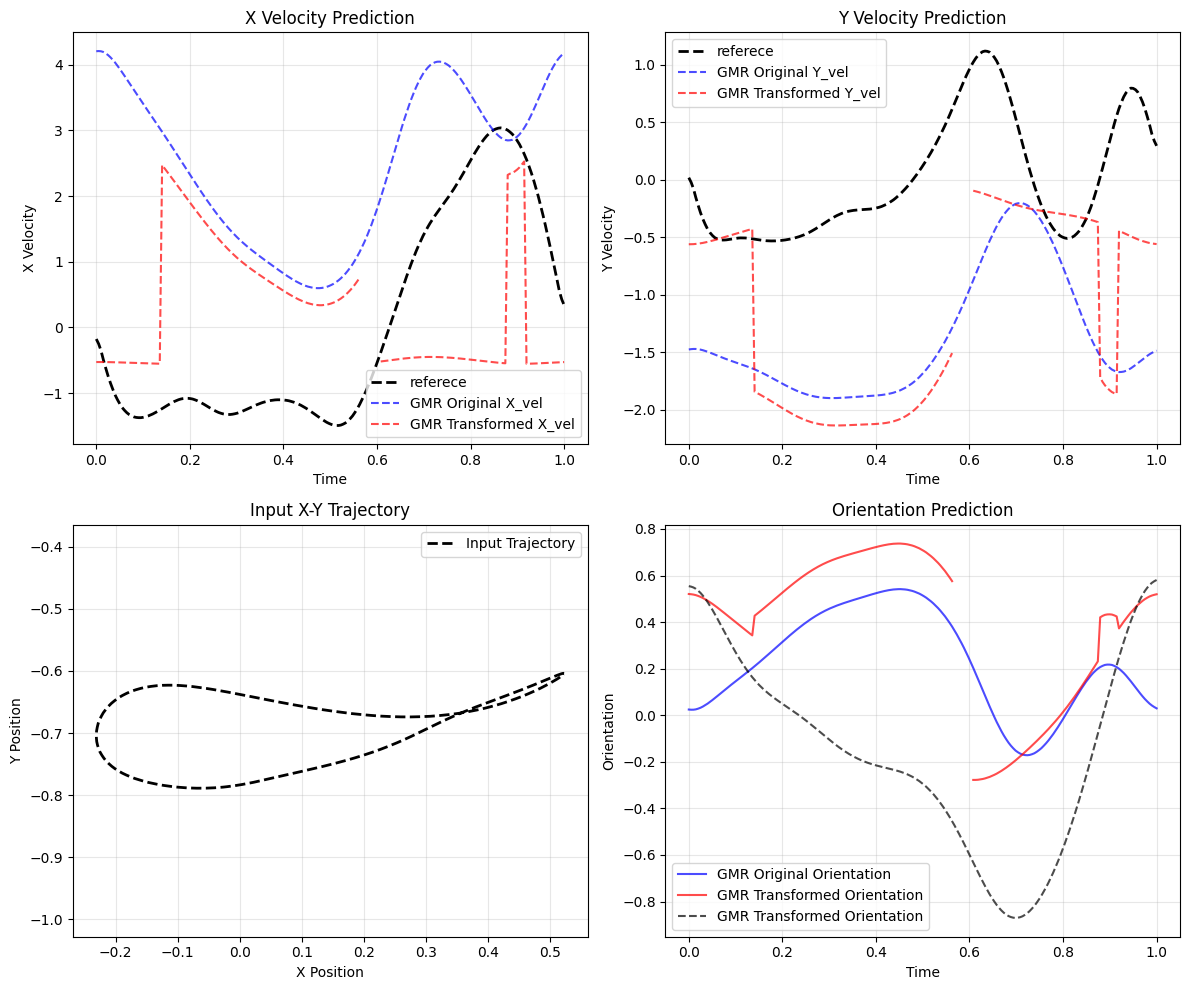

In [17]:
# === Step 6: Plot the obtained trajectory ===
# Generate input positions for prediction
# Use the original X, Y positions as input
input_positions = traj_fr1[:, :2]  # X, Y positions
reference_vel = traj_fr1[:, 2:4]
reference_ori = traj_fr1[:, 4]
ref_time = traj_fr1[:, 5]


# Predict from both GMR models
pred_original_mean, pred_original_cov = gmr.predict(input_positions)
pred_transformed_mean, pred_transformed_cov = gmr_transformed.predict(input_positions)

# Extract predicted X, Y positions (they are part of the output)
# Since we used X,Y as input, the output contains: X_vel, Y_vel, orientation
# But we can also plot the velocities


fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot original vs transformed X position over time
axes[0, 0].plot(ref_time, reference_vel[: , 0], 'k--', label='referece', linewidth=2)
axes[0, 0].plot(ref_time, pred_original_mean[:, 0], 'b--', label='GMR Original X_vel', alpha=0.7)
axes[0, 0].plot(ref_time, pred_transformed_mean[:, 0], 'r--', label='GMR Transformed X_vel', alpha=0.7)
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('X Velocity')
axes[0, 0].set_title('X Velocity Prediction')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot original vs transformed Y position over time
axes[0, 1].plot(ref_time,reference_vel[: , 1], 'k--', label='referece', linewidth=2)
axes[0, 1].plot(ref_time, pred_original_mean[:, 1], 'b--', label='GMR Original Y_vel', alpha=0.7)
axes[0, 1].plot(ref_time, pred_transformed_mean[:, 1], 'r--', label='GMR Transformed Y_vel', alpha=0.7)
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Y Velocity')
axes[0, 1].set_title('Y Velocity Prediction')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot X-Y trajectory
axes[1, 0].plot(input_positions[:, 0], input_positions[:, 1], 'k--', label='Input Trajectory', linewidth=2)
axes[1, 0].set_xlabel('X Position')
axes[1, 0].set_ylabel('Y Position')
axes[1, 0].set_title('Input X-Y Trajectory')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axis('equal')

# Plot orientation prediction
axes[1, 1].plot(ref_time, pred_original_mean[:, 2], 'b-', label='GMR Original Orientation', alpha=0.7)
axes[1, 1].plot(ref_time, pred_transformed_mean[:, 2], 'r-', label='GMR Transformed Orientation', alpha=0.7)
axes[1, 1].plot(ref_time, reference_ori, 'k--', label='GMR Transformed Orientation', alpha=0.7)
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Orientation')
axes[1, 1].set_title('Orientation Prediction')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()




Prediction shapes:
Input shape: (200, 2)
Original prediction mean shape: (200, 4)
Transformed prediction mean shape: (200, 4)


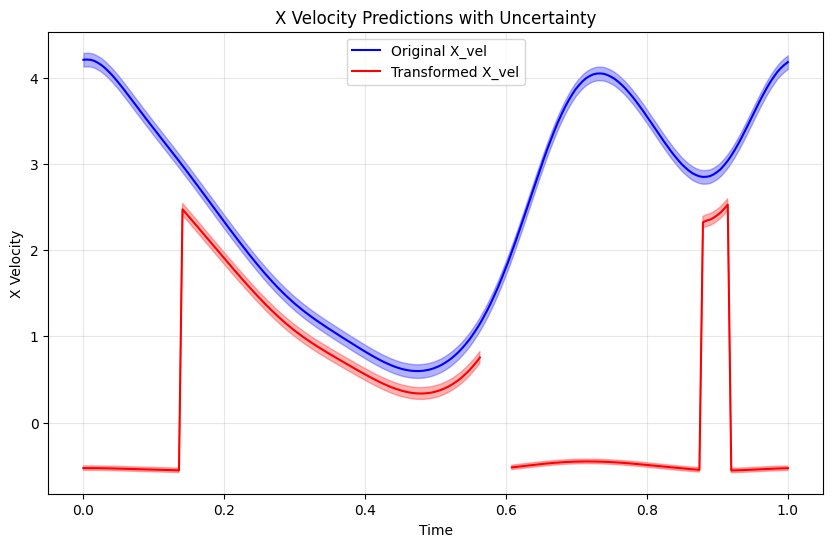

In [18]:
# Print prediction shapes for verification
print(f"\nPrediction shapes:")
print(f"Input shape: {input_positions.shape}")  # (200, 2)
print(f"Original prediction mean shape: {pred_original_mean.shape}")  # (200, 3) - X_vel, Y_vel, orientation
print(f"Transformed prediction mean shape: {pred_transformed_mean.shape}")  # (200, 3)

# Optionally, plot uncertainty (standard deviation)
fig2, ax = plt.subplots(1, 1, figsize=(10, 6))

# Extract standard deviations
std_original = np.sqrt(np.diagonal(pred_original_cov, axis1=1, axis2=2))
std_transformed = np.sqrt(np.diagonal(pred_transformed_cov, axis1=1, axis2=2))

# Plot X velocity with uncertainty bands
time = ref_time
ax.plot(time, pred_original_mean[:, 0], 'b-', label='Original X_vel')
ax.fill_between(time, 
                pred_original_mean[:, 0] - std_original[:, 0],
                pred_original_mean[:, 0] + std_original[:, 0],
                alpha=0.3, color='blue')

ax.plot(time, pred_transformed_mean[:, 0], 'r-', label='Transformed X_vel')
ax.fill_between(time,
                pred_transformed_mean[:, 0] - std_transformed[:, 0],
                pred_transformed_mean[:, 0] + std_transformed[:, 0],
                alpha=0.3, color='red')

ax.set_xlabel('Time')
ax.set_ylabel('X Velocity')
ax.set_title('X Velocity Predictions with Uncertainty')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()